<h1 style="color:red;">Data Loading, Exploration and Preprocessing</h1>

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
import optuna
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import joblib

In [129]:
users = pd.read_csv('synthetic_users.csv') 
events = pd.read_csv('synthetic_events.csv') 
interactions = pd.read_csv('synthetic_interactions.csv')  

print("Users:")
print(users.head())
print("\nEvents:")
print(events.head())
print("\nInteractions:")
print(interactions.head())

Users:
  user_id  gender age_group      role
0  user_0    male     26-35  attendee
1  user_1  female     26-35  attendee
2  user_2    male     26-35  attendee
3  user_3    male     36-50  attendee
4  user_4    male     26-35  attendee

Events:
  event_id category  popularity_score  event_date  is_weekend
0  event_0   Sports              0.96  2025-09-06        True
1  event_1    Movie              0.20  2025-08-04       False
2  event_2    Movie              0.95  2025-07-29       False
3  event_3    Movie              0.99  2025-09-13        True
4  event_4  Theater              0.71  2025-08-14       False

Interactions:
    user_id   event_id
0  user_870  event_209
1  user_101  event_120
2  user_628   event_19
3  user_134  event_127
4   user_57  event_190


<h2>Exploratory Data Analysis (EDA) - Users</h2>

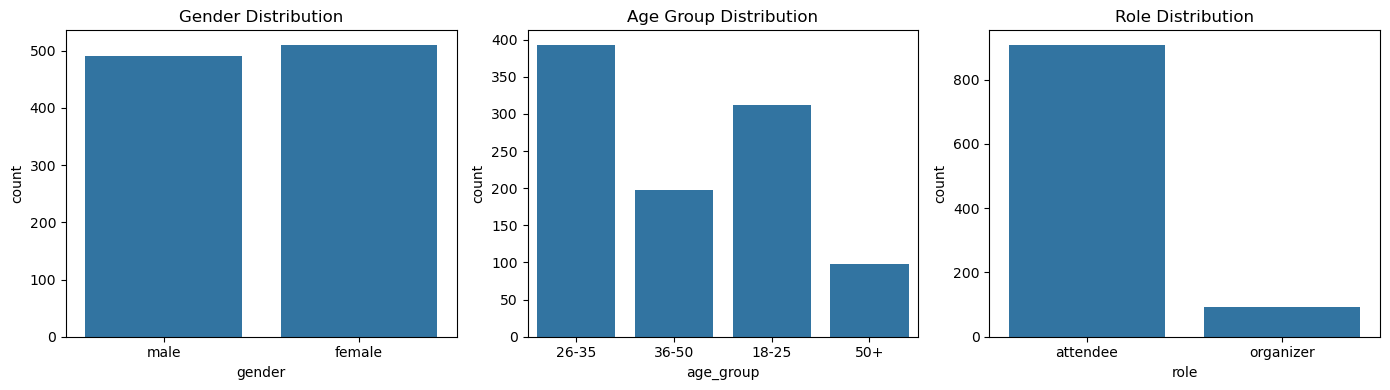

In [132]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.countplot(data=users, x='gender')
plt.title('Gender Distribution')

plt.subplot(1,3,2)
sns.countplot(data=users, x='age_group')
plt.title('Age Group Distribution')

plt.subplot(1,3,3)
sns.countplot(data=users, x='role')
plt.title('Role Distribution')

plt.tight_layout()
plt.show()


<h2>Exploratory Data Analysis (EDA) - Events</h2>

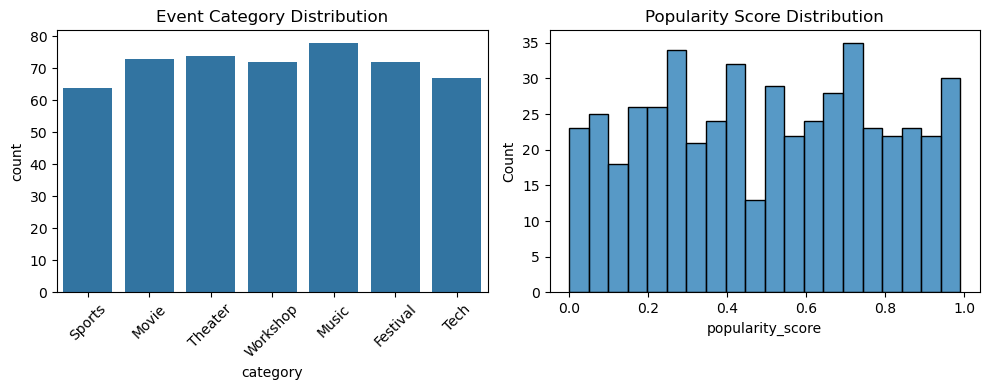

In [121]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(data=events, x='category')
plt.title('Event Category Distribution')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.histplot(data=events, x='popularity_score', bins=20)
plt.title('Popularity Score Distribution')

plt.tight_layout()
plt.show()


<h2>Interaction Counts Analysis</h2>

In [124]:
print("\nInteractions per user:")
print(interactions['user_id'].value_counts().describe())

print("\nInteractions per event:")
print(interactions['event_id'].value_counts().describe())



Interactions per user:
count    1000.0000
mean       10.0000
std         3.0831
min         2.0000
25%         8.0000
50%        10.0000
75%        12.0000
max        21.0000
Name: count, dtype: float64

Interactions per event:
count    137.000000
mean      72.992701
std       83.221047
min        1.000000
25%        3.000000
50%       31.000000
75%      133.000000
max      289.000000
Name: count, dtype: float64


<h2>Encoding Categorical Variables for Modeling</h2>

In [135]:
users_encoded = users.copy()
users_encoded['gender'] = users_encoded['gender'].astype('category').cat.codes
users_encoded['age_group'] = users_encoded['age_group'].astype('category').cat.codes
users_encoded['role'] = users_encoded['role'].astype('category').cat.codes

events_encoded = events.copy()
events_encoded['category'] = events_encoded['category'].astype('category').cat.codes

print("\nEncoded Users sample:")
print(users_encoded.head())

print("\nEncoded Events sample:")
print(events_encoded.head())



Encoded Users sample:
  user_id  gender  age_group  role
0  user_0       1          1     0
1  user_1       0          1     0
2  user_2       1          1     0
3  user_3       1          2     0
4  user_4       1          1     0

Encoded Events sample:
  event_id  category  popularity_score  event_date  is_weekend
0  event_0         3              0.96  2025-09-06        True
1  event_1         1              0.20  2025-08-04       False
2  event_2         1              0.95  2025-07-29       False
3  event_3         1              0.99  2025-09-13        True
4  event_4         5              0.71  2025-08-14       False


<h2>Removing uneeded data (users with role organizer )  </h2>

In [138]:
users = users[users['role'] != 'organizer']
print(f"Users after removing organizers: {users.shape[0]}")

Users after removing organizers: 908


<h2>Remove interactions related to removed users</h2>

In [141]:
valid_user_ids = set(users['user_id'])
interactions = interactions[interactions['user_id'].isin(valid_user_ids)]
print(f"Interactions after removing organizer-related ones: {interactions.shape[0]}")

Interactions after removing organizer-related ones: 9086


<h2>Encode categorical columns</h2>

In [144]:
users_encoded = users.copy()
users_encoded['gender'] = users_encoded['gender'].astype('category').cat.codes
users_encoded['age_group'] = users_encoded['age_group'].astype('category').cat.codes
users_encoded['role'] = users_encoded['role'].astype('category').cat.codes  # expected to be all 0 now (attendee)

# Encode event category
events_encoded = events.copy()
events_encoded['category'] = events_encoded['category'].astype('category').cat.codes

<h2>Scale popularity_score</h2>

In [ ]:
scaler = MinMaxScaler()
events_encoded['popularity_score'] = scaler.fit_transform(events_encoded[['popularity_score']])

<h2>Convert event_date to datetime format</h2>

In [ ]:
events_encoded['event_date'] = pd.to_datetime(events_encoded['event_date'])

<h2>Final check: print samples and shapes after cleaning and encoding</h2>

In [149]:
print("\nCleaned Users Sample:")
print(users_encoded.head())

print("\nCleaned Events Sample:")
print(events_encoded.head())

print("\nCleaned Interactions Sample:")
print(interactions.head())


Cleaned Users Sample:
  user_id  gender  age_group  role
0  user_0       1          1     0
1  user_1       0          1     0
2  user_2       1          1     0
3  user_3       1          2     0
4  user_4       1          1     0

Cleaned Events Sample:
  event_id  category  popularity_score  event_date  is_weekend
0  event_0         3              0.96  2025-09-06        True
1  event_1         1              0.20  2025-08-04       False
2  event_2         1              0.95  2025-07-29       False
3  event_3         1              0.99  2025-09-13        True
4  event_4         5              0.71  2025-08-14       False

Cleaned Interactions Sample:
    user_id   event_id
0  user_870  event_209
1  user_101  event_120
2  user_628   event_19
4   user_57  event_190
5  user_430    event_0


<h1 style="color:red;">LightFM Dataset Preparation</h1>

<h2>Build interaction matrix from (user_id, event_id) pairs</h2> 

In [155]:
dataset = Dataset()

user_ids = users_encoded['user_id'].unique()
event_ids = events_encoded['event_id'].unique()

user_features_raw = users_encoded.set_index('user_id')[['gender', 'age_group', 'role']]
user_feature_tuples = [
    (uid, [f"gender:{g}", f"age_group:{a}", f"role:{r}"])
    for uid, g, a, r in zip(user_features_raw.index, user_features_raw['gender'], user_features_raw['age_group'], user_features_raw['role'])
]

event_features_raw = events_encoded.set_index('event_id')[['category', 'popularity_score', 'is_weekend']]
event_feature_tuples = [
    (eid, [f"category:{c}", f"is_weekend:{w}"])
    for eid, c, w in zip(event_features_raw.index, event_features_raw['category'], event_features_raw['is_weekend'])
]

dataset.fit(
    users=user_ids,
    items=event_ids,
    user_features=set(f for _, feats in user_feature_tuples for f in feats),
    item_features=set(f for _, feats in event_feature_tuples for f in feats)
)

(interactions_matrix, weights) = dataset.build_interactions(
    [(row['user_id'], row['event_id']) for idx, row in interactions.iterrows()]
)
print(f"Interaction matrix shape: {interactions_matrix.shape}")

user_features = dataset.build_user_features(user_feature_tuples)
item_features = dataset.build_item_features(event_feature_tuples)

print("User features sparse:", user_features.shape)
print("Item features sparse:", item_features.shape)


Interaction matrix shape: (908, 500)
User features sparse: (908, 915)
Item features sparse: (500, 509)


<h1 style="color:red;">Training</h1>

<h2>Train-Test Split</h2>

In [ ]:
train, test = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=42)
print(f"Train interactions: {train.nnz} | Test interactions: {test.nnz}")

<h2>Hyperparameter Tuning with Optuna</h2>
<p>We use Optuna to automatically and efficiently find the best hyperparameters for the LightFM model. Optuna intelligently explores the parameter space by learning from previous trials, allowing faster convergence to optimal values compared to manual or random searches. This results in improved model performance with fewer training iterations and less computational effort.</p>

In [166]:
def objective(trial):

    model = LightFM(
        no_components=trial.suggest_int("no_components", 20, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        item_alpha=trial.suggest_float("item_alpha", 1e-6, 1e-2, log=True),
        user_alpha=trial.suggest_float("user_alpha", 1e-6, 1e-2, log=True),
        loss="logistic",
        random_state=42
    )

 
    model.fit(train,
              user_features=user_features,
              item_features=item_features,
              epochs=20,
              num_threads=4,
              verbose=False)


    precision = precision_at_k(model, test,
                               user_features=user_features,
                               item_features=item_features,
                               k=5).mean()
    return precision


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best Precision@5:", study.best_value)

[I 2025-07-29 02:13:53,455] A new study created in memory with name: no-name-bb713879-d830-451a-9635-ab85b0f8d17b
[I 2025-07-29 02:13:55,295] Trial 0 finished with value: 0.0540880486369133 and parameters: {'no_components': 68, 'learning_rate': 0.00028509556719398684, 'item_alpha': 6.159341693569425e-06, 'user_alpha': 1.7334632175115133e-06}. Best is trial 0 with value: 0.0540880486369133.
[I 2025-07-29 02:13:57,809] Trial 1 finished with value: 0.0540880486369133 and parameters: {'no_components': 94, 'learning_rate': 0.06450116920725556, 'item_alpha': 0.00011366875573526385, 'user_alpha': 4.007835455594576e-05}. Best is trial 0 with value: 0.0540880486369133.
[I 2025-07-29 02:14:00,146] Trial 2 finished with value: 0.0540880486369133 and parameters: {'no_components': 91, 'learning_rate': 0.00017320069385404777, 'item_alpha': 1.529723191893225e-05, 'user_alpha': 0.004667056476918443}. Best is trial 0 with value: 0.0540880486369133.
[I 2025-07-29 02:14:02,216] Trial 3 finished with valu

Best parameters: {'no_components': 68, 'learning_rate': 0.00028509556719398684, 'item_alpha': 6.159341693569425e-06, 'user_alpha': 1.7334632175115133e-06}
Best Precision@5: 0.0540880486369133


<h2> Train Final Model with Best Parameters</h2>

In [169]:
best_params = study.best_params
model = LightFM(**best_params, random_state=42)

model.fit(train,
          user_features=user_features,
          item_features=item_features,
          epochs=20,
          num_threads=4)

<h1 style="color:red;">Evaluation</h1>
<ol>
    <li> <b>Precision@5: 0.0541</b>
This means that, on average, about 5.4% of the top 5 recommendations for a user are relevant or actually interacted with by the user. It reflects the accuracy of the top recommendations.</li>
    <li> <b>Recall@5: 0.1214</b>
This indicates that the system is able to retrieve around 12.1% of all relevant items (items the user interacted with) within the top 5 recommendations. It shows how well the system covers the user’s interests.</li>
    <li><b> AUC Score: 0.7430</b>
       
The Area Under the Curve (AUC) score of 0.743 means the model has a good overall ability to distinguish between items a user will interact with and those they will not. A score closer to 1 is better, so 0.743 shows solid predictive performance.

</li>
</ol>

In [174]:
precision = precision_at_k(model, test,
                           user_features=user_features,
                           item_features=item_features,
                           k=5).mean()
recall = recall_at_k(model, test,
                     user_features=user_features,
                     item_features=item_features,
                     k=5).mean()
auc = auc_score(model, test,
                user_features=user_features,
                item_features=item_features).mean()

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"AUC Score: {auc:.4f}")


Precision@5: 0.0541
Recall@5: 0.1214
AUC Score: 0.7430


<h2>Generate Top-N Recommendations</h2>

In [177]:
def generate_recommendations(model, user_ids, interactions_matrix, user_features, item_features, n=5):
    n_users, n_items = interactions_matrix.shape
    recommendations = {}

    for user_idx in range(n_users):
        scores = model.predict(user_ids=user_idx,
                               item_ids=np.arange(n_items),
                               user_features=user_features,
                               item_features=item_features)

        known_items = interactions_matrix.tocsr()[user_idx].indices
        scores[known_items] = -np.inf 

        top_items = np.argsort(-scores)[:n]
        recommendations[user_ids[user_idx]] = top_items

    return recommendations

<h2>Mapping & Displaying Recommendations (for user with id 0 )</h2> <p>this is used to have a better insight about the recommendation performance and the pattern followed</p>

In [182]:
inv_event_id_map = {v: k for k, v in dataset.mapping()[2].items()}
user_id = 0  
recommended_ids = recommendations[user_id]

print("Recommended events for user_id:", user_id)
for eid_internal in recommended_ids:
    event_id = inv_event_id_map[eid_internal]
    print(events[events['event_id'] == event_id])


Recommended events for user_id: 0
  event_id category  popularity_score  event_date  is_weekend
5  event_5    Movie              0.98  2025-08-12       False
    event_id category  popularity_score  event_date  is_weekend
17  event_17    Movie              0.96  2025-07-30       False
      event_id category  popularity_score  event_date  is_weekend
177  event_177    Movie              0.98  2025-08-07       False
      event_id category  popularity_score  event_date  is_weekend
120  event_120    Movie              0.97  2025-09-01       False
  event_id category  popularity_score  event_date  is_weekend
2  event_2    Movie              0.95  2025-07-29       False


In [184]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
inv_user_id_map = {v: k for k, v in user_id_map.items()}
real_user_id = inv_user_id_map[0]
print(f"Internal user ID 0 corresponds to user_id: {real_user_id}")
user_interactions = interactions[interactions['user_id'] == real_user_id]
print("Events user interacted with:")
print(user_interactions)
interacted_event_info = user_interactions.merge(events, on='event_id', how='left')
print(interacted_event_info)

Internal user ID 0 corresponds to user_id: user_0
Events user interacted with:
     user_id   event_id
61    user_0   event_99
1310  user_0  event_310
2927  user_0  event_405
3228  user_0  event_199
3373  user_0  event_355
5340  user_0  event_127
7251  user_0   event_19
7598  user_0  event_269
9849  user_0  event_269
  user_id   event_id  category  popularity_score  event_date  is_weekend
0  user_0   event_99      Tech              0.94  2025-08-10        True
1  user_0  event_310      Tech              0.98  2025-08-01       False
2  user_0  event_405      Tech              0.91  2025-08-26       False
3  user_0  event_199    Sports              0.97  2025-09-14        True
4  user_0  event_355      Tech              0.92  2025-09-17       False
5  user_0  event_127  Workshop              0.97  2025-07-31       False
6  user_0   event_19    Sports              0.98  2025-08-02        True
7  user_0  event_269  Workshop              0.97  2025-09-01       False
8  user_0  event_269  Wo

<h2>Exploring Recommendation Diversity and Novelty</h2> <p>To evaluate the quality of our recommendation system beyond accuracy, we analyze how diverse (varied) and serendipitous (unexpected but relevant) the suggested items are. This helps ensure users receive a mix of familiar and novel content that keeps the experience engaging and personalized.</p>
<ol>
    <li>A lower value of Diversity means less variation in content types.
</li>
<li>A high Serendipity score means that many of the recommended items are new to the user and highly popular, indicating that the system is effectively introducing appealing and unexpected content.</li>
</ol>

In [197]:
def get_recommendations_for_user(user_id, model, dataset, user_features, item_features, events_df, top_n=10):
    user_mapping = dataset.mapping()[0]
    event_mapping = dataset.mapping()[2] 
    inv_event_mapping = {v: k for k, v in event_mapping.items()}

    if user_id not in user_mapping:
        raise ValueError(f"User {user_id} not in dataset.")

    user_internal_id = user_mapping[user_id]

    scores = model.predict(user_internal_id, np.arange(len(event_mapping)), user_features=user_features, item_features=item_features)

    top_items_idx = np.argsort(-scores)[:top_n]
    
    recommended_event_ids = [inv_event_mapping[i] for i in top_items_idx]

    return recommended_event_ids, scores[top_items_idx]

In [199]:

def diversity(recommendations, events_df):
    categories = events_df[events_df['event_id'].isin(recommendations)]['category']
    if len(categories) == 0:
        return 0
    return categories.nunique() / len(categories)

In [201]:
def serendipity(recommendations, user_history, events_df):
    novel_items = set(recommendations) - set(user_history)
    if len(recommendations) == 0:
        return 0
    top_serendipitous = events_df[
        (events_df['event_id'].isin(novel_items)) & 
        (events_df['popularity_score'] > 0.9)
    ]
    return len(top_serendipitous) / len(recommendations)

In [203]:
user_to_test = 'user_0'

user_history = interactions[interactions['user_id'] == user_to_test]['event_id'].tolist()

recommended_events, rec_scores = get_recommendations_for_user(
    user_id=user_to_test,
    model=model,
    dataset=dataset,
    user_features=user_features,
    item_features=item_features,
    events_df=events_encoded,
    top_n=10
)

div_score = diversity(recommended_events, events_encoded)
ser_score = serendipity(recommended_events, user_history, events_encoded)

print(f"Recommendations for {user_to_test}: {recommended_events}")
print(f"Diversity: {div_score:.3f}")
print(f"Serendipity: {ser_score:.3f}")


Recommendations for user_0: ['event_5', 'event_17', 'event_177', 'event_120', 'event_2', 'event_310', 'event_141', 'event_182', 'event_410', 'event_451']
Diversity: 0.200
Serendipity: 0.900


<h2>Import the model</h2>

In [224]:
joblib.dump(model, 'lightfm_model.pkl')

['lightfm_model.pkl']